# 전통적 시계열 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다.
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다.
    * 예를 들면
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.
        * 예측된 수요량과 현 재고, 안전재고량 등을 감안하여 발주량은 결정되고,
        * 발주 수량은 6월3일 새벽에 매장에 입고되어 6월3일에 판매할 수 있습니다.
* 발주 최적화를 위한 수요량 예측 : 2일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

* 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) Data Loading

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[data['date'].between('2013-06-01', '2015-03-02')].reset_index(drop = True)
data

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
...,...,...,...,...,...
635,2015-02-26,28,83,611,48
636,2015-02-27,28,91,696,74
637,2015-02-28,28,112,774,77
638,2015-03-01,28,113,967,75


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

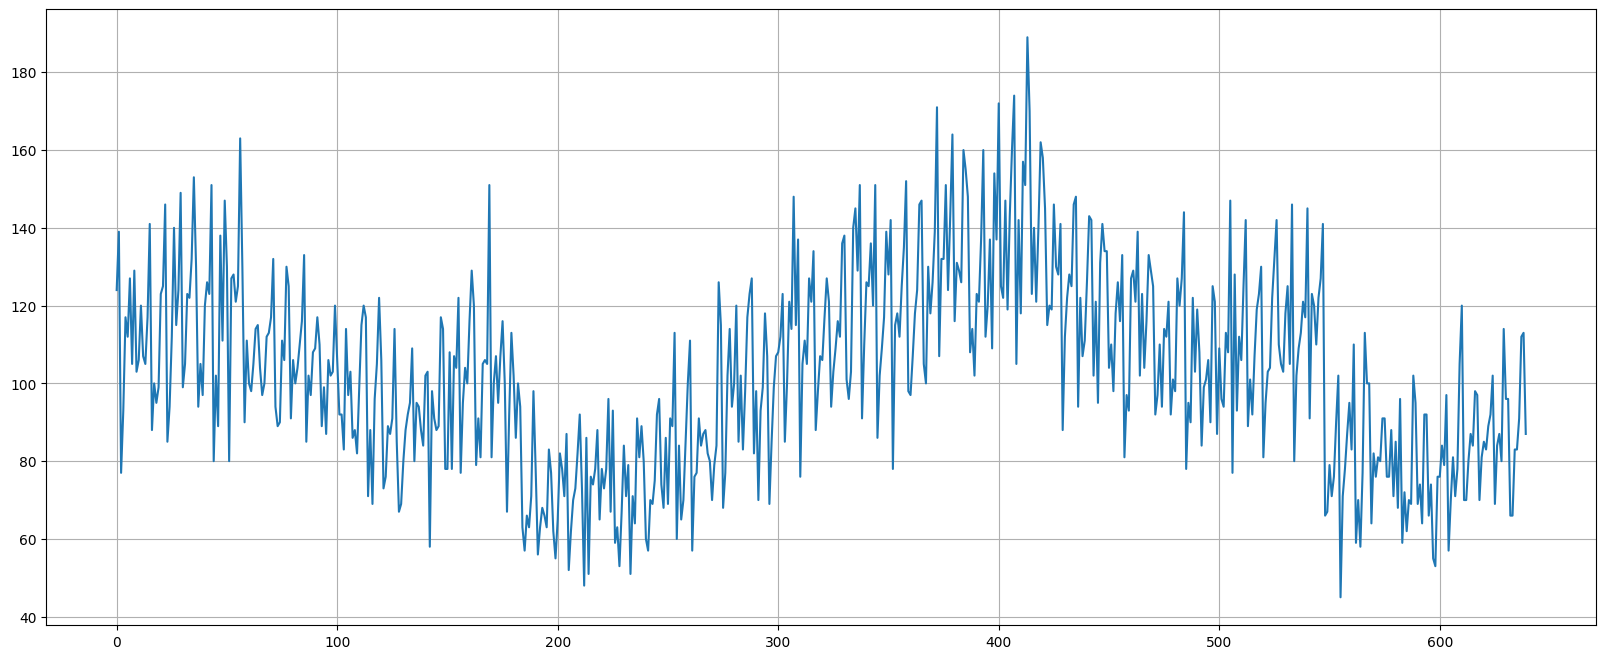

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 2일 후 수요량을 예측하기 위한 y 만들기

In [6]:
data['y'] = data['sales'].shift(-2)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,77.0
1,2013-06-02,28,139,1019,93,93.0
2,2013-06-03,28,77,676,65,117.0
3,2013-06-04,28,93,764,80,112.0
4,2013-06-05,28,117,818,80,127.0


,date,item,sales,tot_sales,comp_sales,y
635,2015-02-26,28,83,611,48,112.0
636,2015-02-27,28,91,696,74,113.0
637,2015-02-28,28,112,774,77,87.0
638,2015-03-01,28,113,967,75,NaN
639,2015-03-02,28,87,651,68,NaN


In [7]:
# 마지막 두 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,91.0
635,2015-02-26,28,83,611,48,112.0
636,2015-02-27,28,91,696,74,113.0
637,2015-02-28,28,112,774,77,87.0


## (2) 데이터 분할

### 1) x, y 나누기

In [8]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 최근 30일 데이터를 Validation Set으로 지정

In [9]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00671
* 정상성 검정(< 0.05) :  0.50371
* 자기상관성 확인(ACF, PACF)


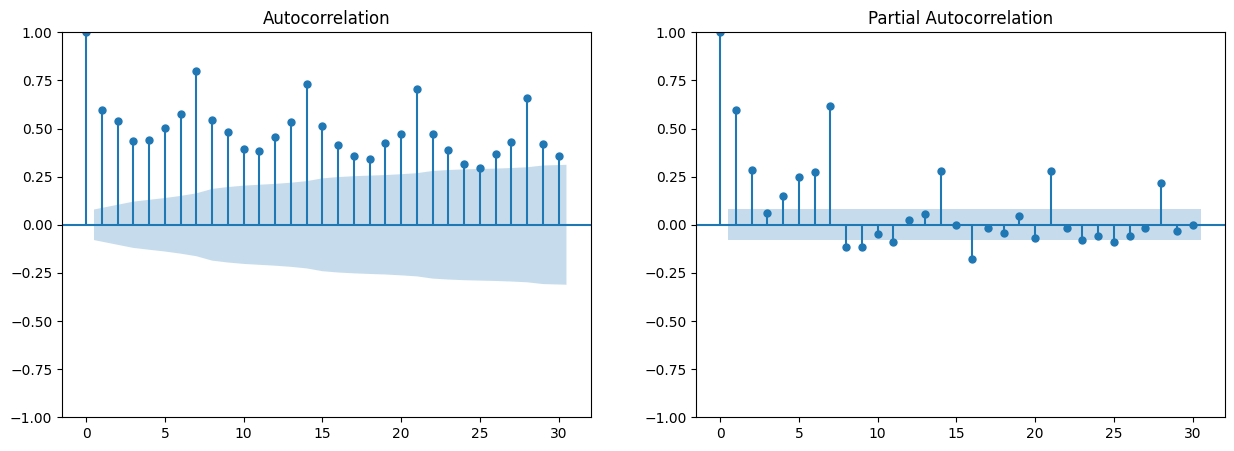

In [10]:
residual_diag(y_train )

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* 초기 차수를 1,1,1로 정하고 모델링을 수행해 봅시다.

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [11]:
# ARIMA 모델링
m1 = sm.tsa.SARIMAX(y_train, order = (1,1,1)).fit()

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.16147
* 정상성 검정(< 0.05) :  1e-05
* 자기상관성 확인(ACF, PACF)


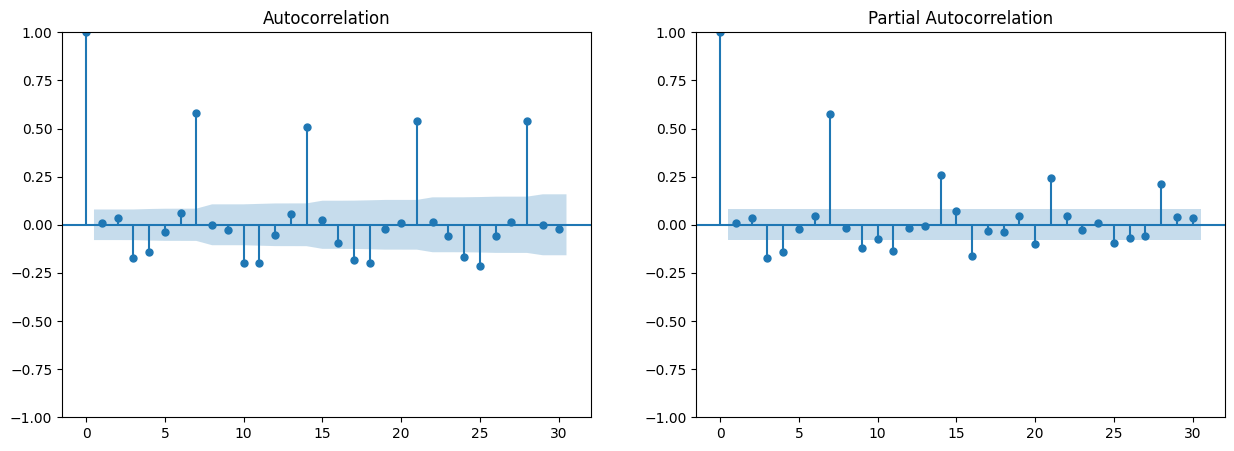

In [12]:
residuals = m1.resid
residual_diag(residuals )

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [13]:
val_size

30

In [14]:
pred1 = m1.forecast(val_size)

print(mean_absolute_error(y_val, pred1))
print(mean_absolute_percentage_error(y_val, pred1))
print(r2_score(y_val, pred1))


12.977607875982805
0.13879413102945512
-0.3517886914927839


* 결과 시각화

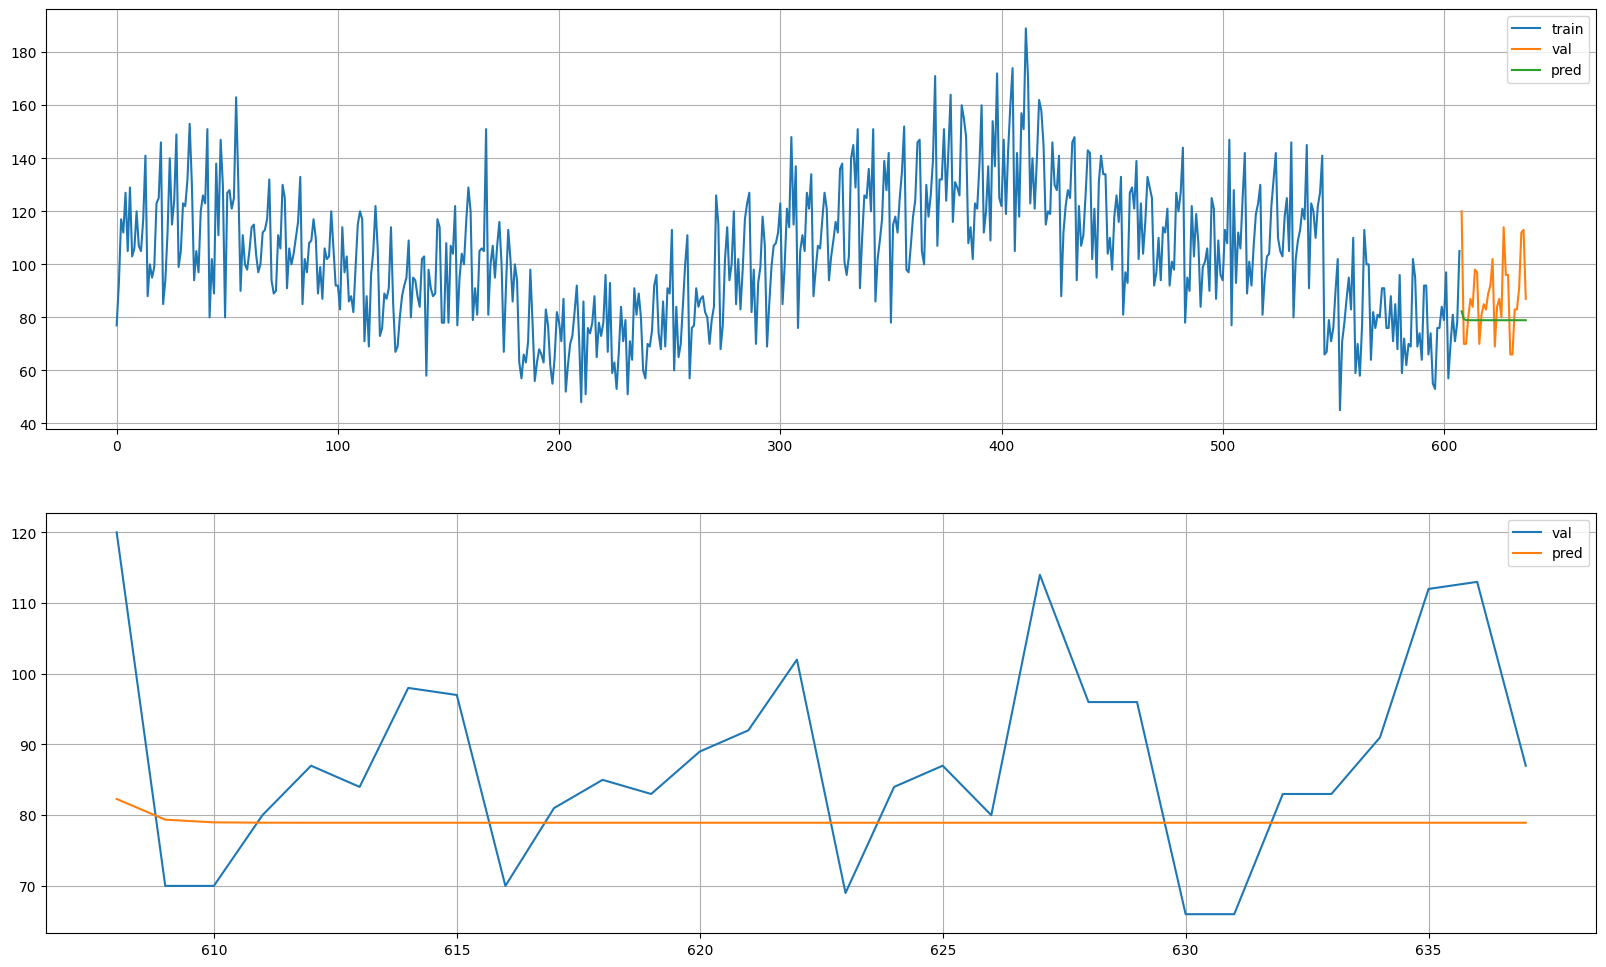

In [15]:
plot_model_result(y_train, y_val, pred1)

## (3) 하이퍼파라미터 튜닝

실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.


### 1) 학습

In [16]:
from itertools import product

* 값의 범위 지정
    * 시간이 많이 소요될 수 있으니 범위를 적절하게 지정하세요.

In [17]:
# product 함수를 이용하여 값의 조합을 구성
p = [2,3,4,5]
q = [2,3,4,5]
d = [1]
iter = list(product(p,d,q))
iter

[(2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5)]

* 튜닝

In [18]:
# 빈 리스트
mae, aic = [],[]

# 반복문으로 모델 생성하고 mae, aic 값 계산 후 저장
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0], i[1], i[2])).fit()
    pred = model_fit.forecast(val_size)
    mae.append(mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 1, 5)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 1, 5)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 1, 5)
(5, 1, 2)
(5, 1, 3)
(5, 1, 4)
(5, 1, 5)


* 튜닝 결과 조회

In [19]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})
result

,"params(p,d,q)",mae,aic
0,"(2, 1, 2)",12.970444,5236.124993
1,"(2, 1, 3)",12.694808,5197.901166
2,"(2, 1, 4)",11.226889,5199.261237
3,"(2, 1, 5)",11.535764,5143.128720
4,"(3, 1, 2)",10.918729,5148.535925
5,"(3, 1, 3)",11.014958,5002.484562
6,"(3, 1, 4)",11.447382,5024.906563
7,"(3, 1, 5)",11.241961,4991.017368
8,"(4, 1, 2)",12.346280,5169.727675
9,"(4, 1, 3)",9.645517,5096.329886


In [20]:
display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
14,"(5, 1, 4)",7.009541,4969.095128


,"params(p,d,q)",mae,aic
11,"(4, 1, 5)",10.164044,4949.956368


In [21]:
# 최적의 하이퍼파라미터로 모델 생성
m1_1 = sm.tsa.SARIMAX(y_train, order = (5,1,4)).fit()


### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.00139
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


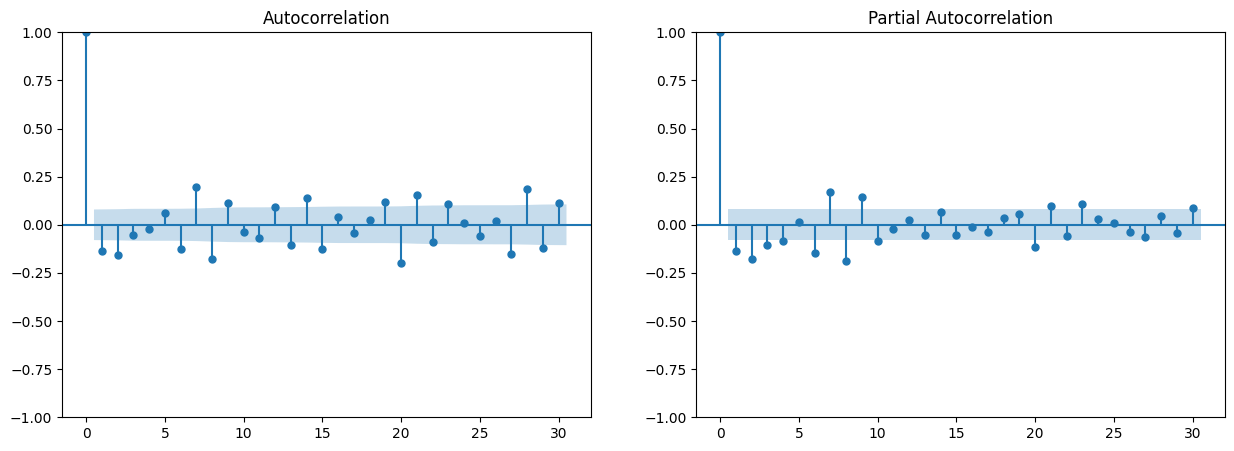

In [22]:
residuals = m1_1.resid
residual_diag(residuals )

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

#### ③ Validation

In [49]:
pred1 = m1_1.forecast(val_size)

print(mean_absolute_error(y_val, pred1))
print(mean_absolute_percentage_error(y_val, pred1))
print(r2_score(y_val, pred1))


7.009540730098422
0.07860689133049041
0.5129652498184871


* 결과 시각화

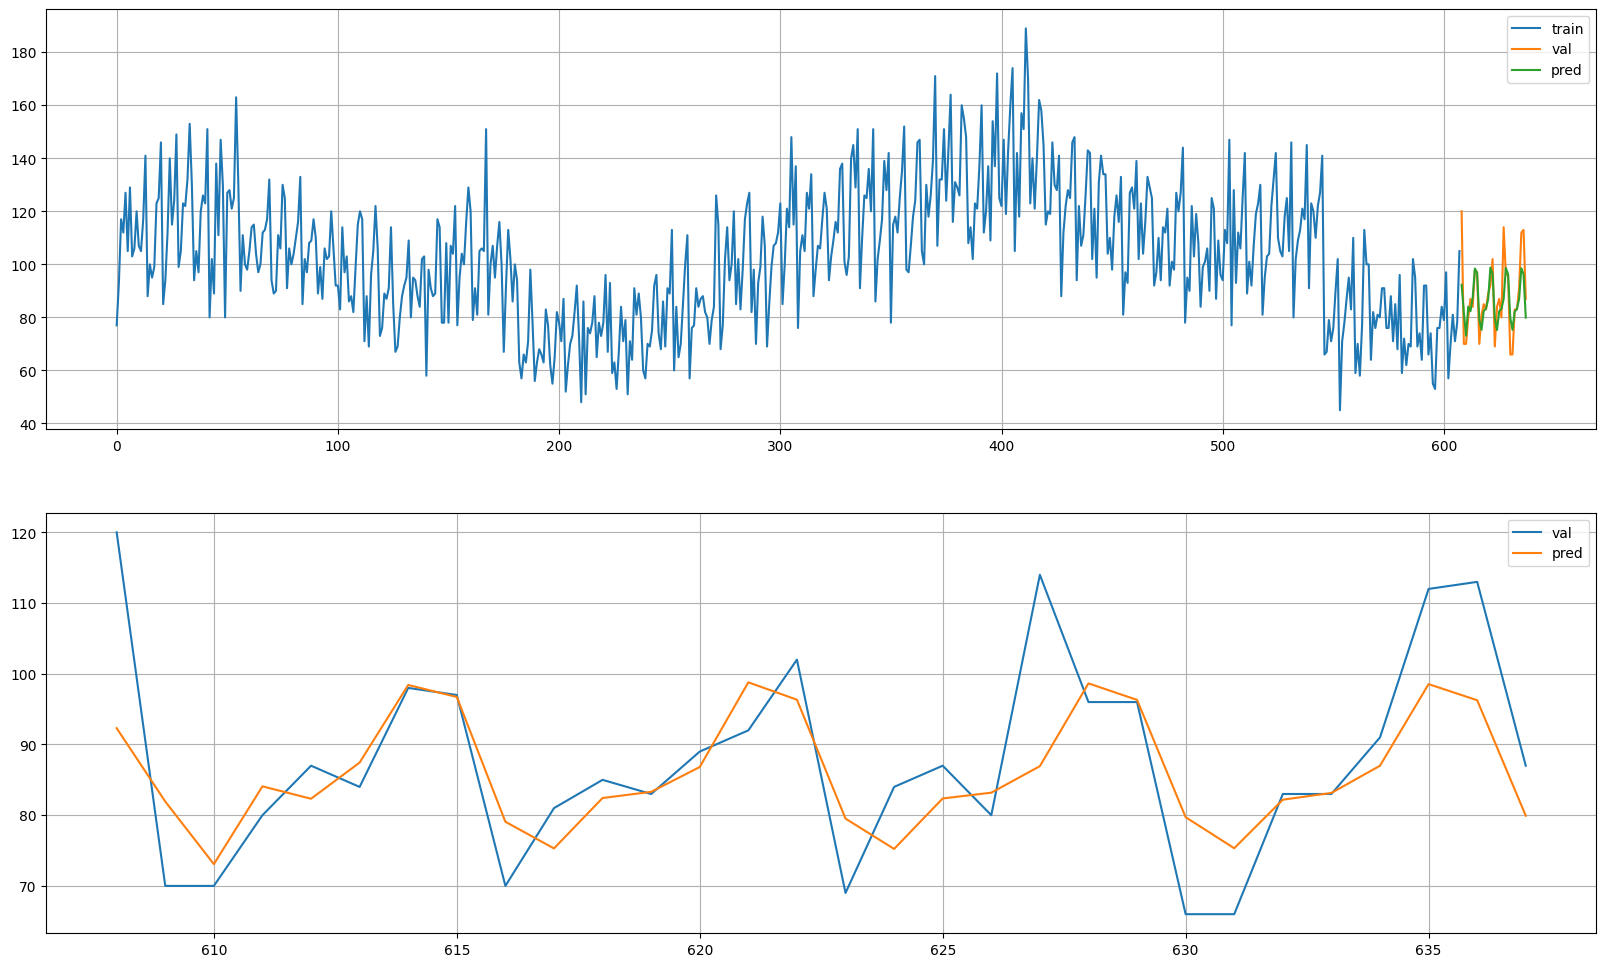

In [24]:
plot_model_result(y_train, y_val, pred1)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습
* Seasonal 하이퍼파라미터(P, D, Q, m) 초기 값으로 1, 1, 1, 7로 모델링

In [25]:
# SARIMA 모델링
m2 = sm.tsa.SARIMAX(y_train, order=(5,1,4), seasonal_order=(1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


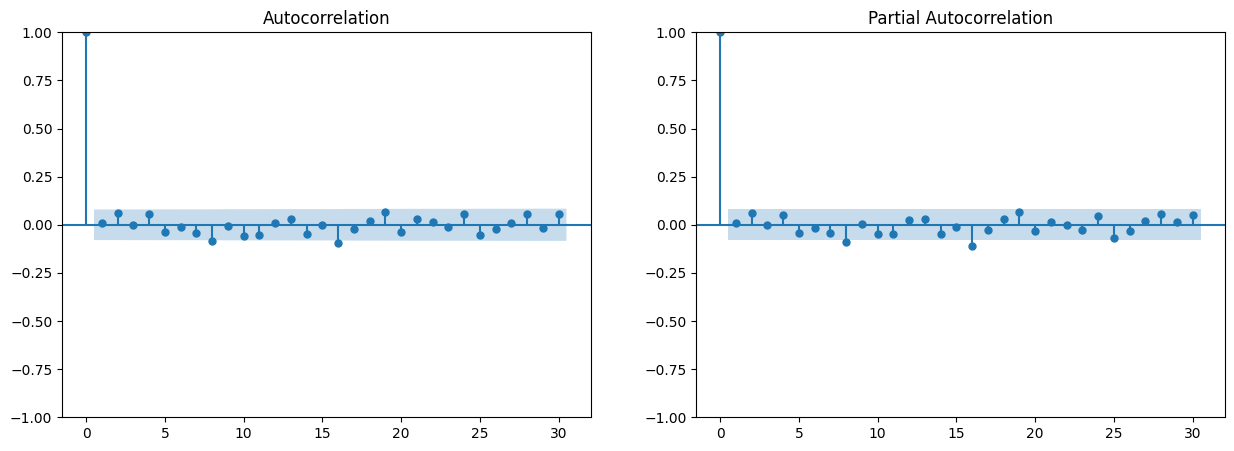

In [26]:
residuals = m2.resid
residual_diag(residuals, lags = 30)

#### ② AIC

In [27]:
print('model2_0 AIC :', m2.aic)

model2_0 AIC : 4692.8500182224325


#### ③ Validation

In [28]:
pred = m2.forecast(val_size)

print('MAE  : ', mean_absolute_error(y_val, pred))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
print('R2   : ', r2_score(y_val, pred))

MAE  :  9.18513229242008
MAPE :  0.10296464019997704
R2   :  0.30094542481814746


* 결과 시각화

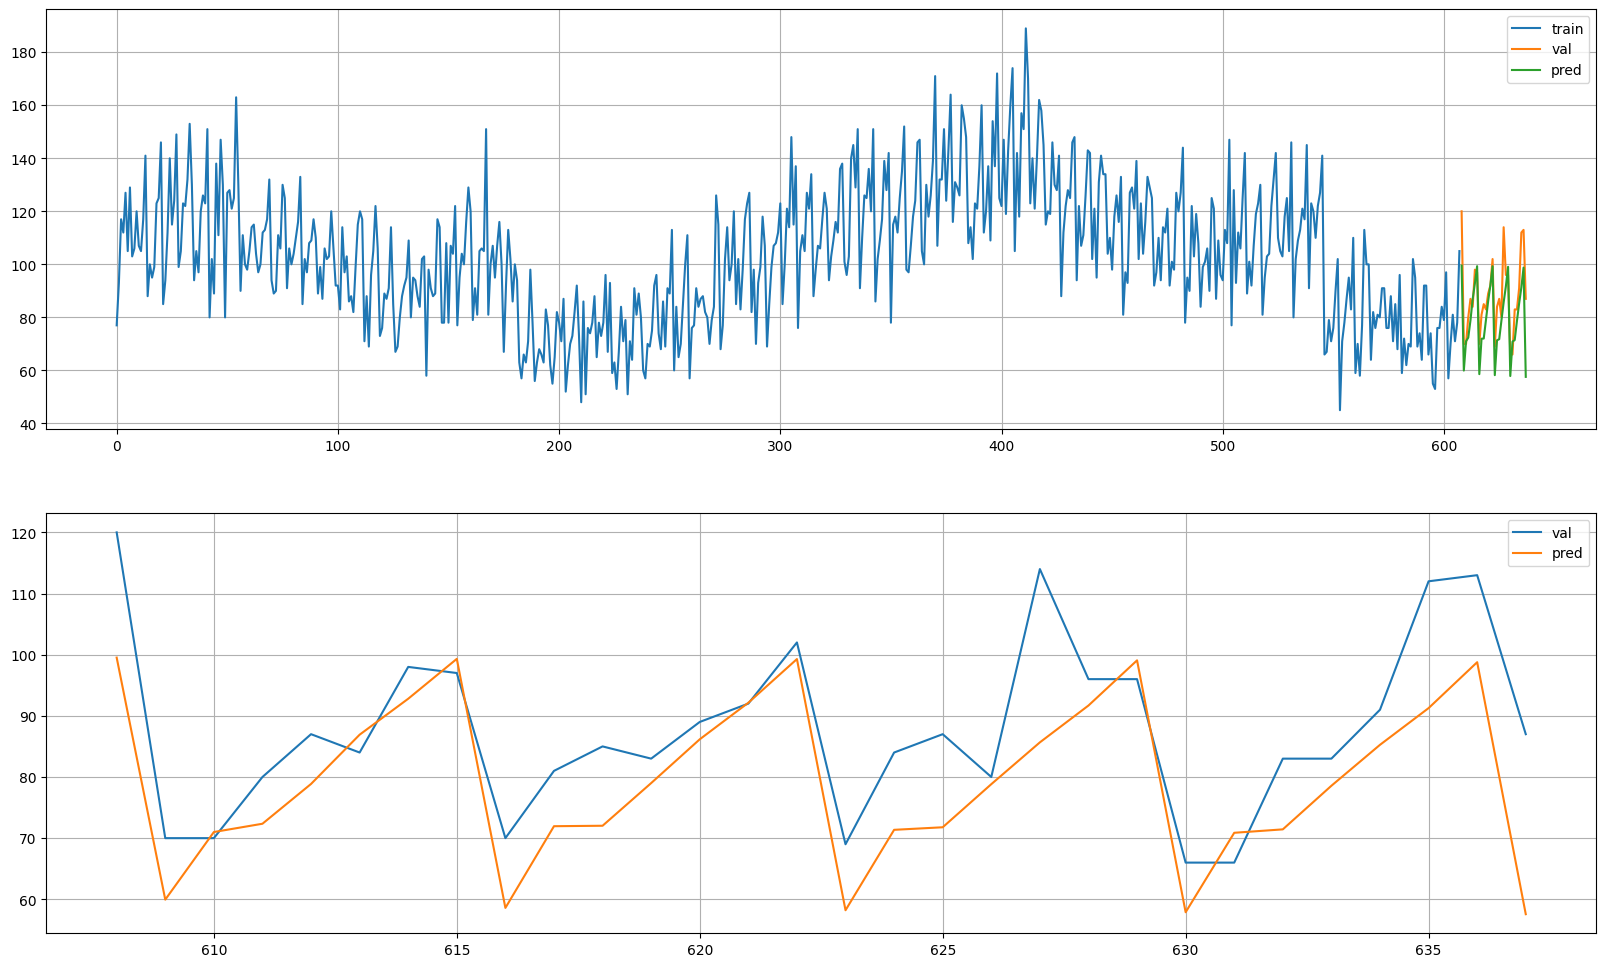

In [29]:
plot_model_result(y_train, y_val, pred)

## (2) 하이퍼파라미터 튜닝

### 1) 학습
* 다음의 범위로 하이퍼 파라미터 튜닝을 진행합시다.(범위를 더 늘리면 시간이 많이 걸립니다.)

    * P : 1,2,3
    * Q : 1,2,3
    * D : 1
    * m : 7

In [30]:
from tqdm import tqdm

In [35]:
P = [1,2,3]
Q = [1,2,3]
D = [1]
m = [7]
mae, aic = [],[]
iter = list(product(P,D,Q,m))

for i in tqdm(iter) :
    model_fit = sm.tsa.SARIMAX(y_train, order=(5,1,4), seasonal_order=(i[0],i[1],i[2],i[3])).fit()
    pred = model_fit.forecast(val_size)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)

100%|██████████| 9/9 [03:17<00:00, 21.90s/it]


In [38]:
result = pd.DataFrame({'params(P,D,Q,m)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q,m)",mae,aic
5,"(2, 1, 3, 7)",9.069568,4698.388175


,"params(P,D,Q,m)",mae,aic
1,"(1, 1, 2, 7)",10.146896,4688.897057


In [39]:
# 최적의 하이퍼파라미터로 모델 생성
m2_1 = sm.tsa.SARIMAX(y_train, order=(5,1,4), seasonal_order=(2,1,3,7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


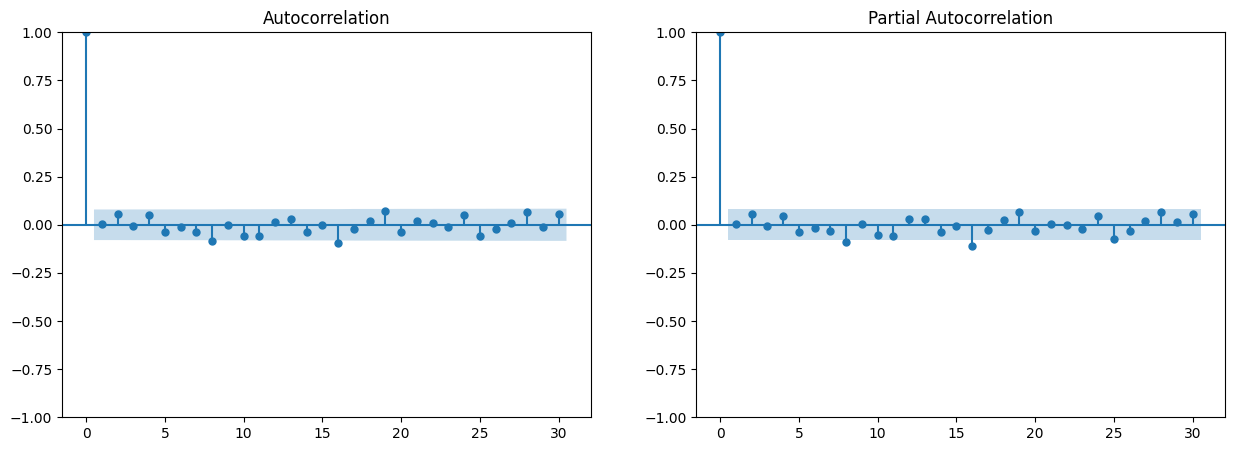

In [40]:
residuals = m2_1.resid
residual_diag(residuals, lags = 30)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

#### ③ Validation

In [41]:
pred = m2_1.forecast(val_size)

print('MAE  : ', mean_absolute_error(y_val, pred))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
print('R2   : ', r2_score(y_val, pred))

MAE  :  9.06956761213446
MAPE :  0.1016592688013218
R2   :  0.3108294928940353


* 결과 시각화

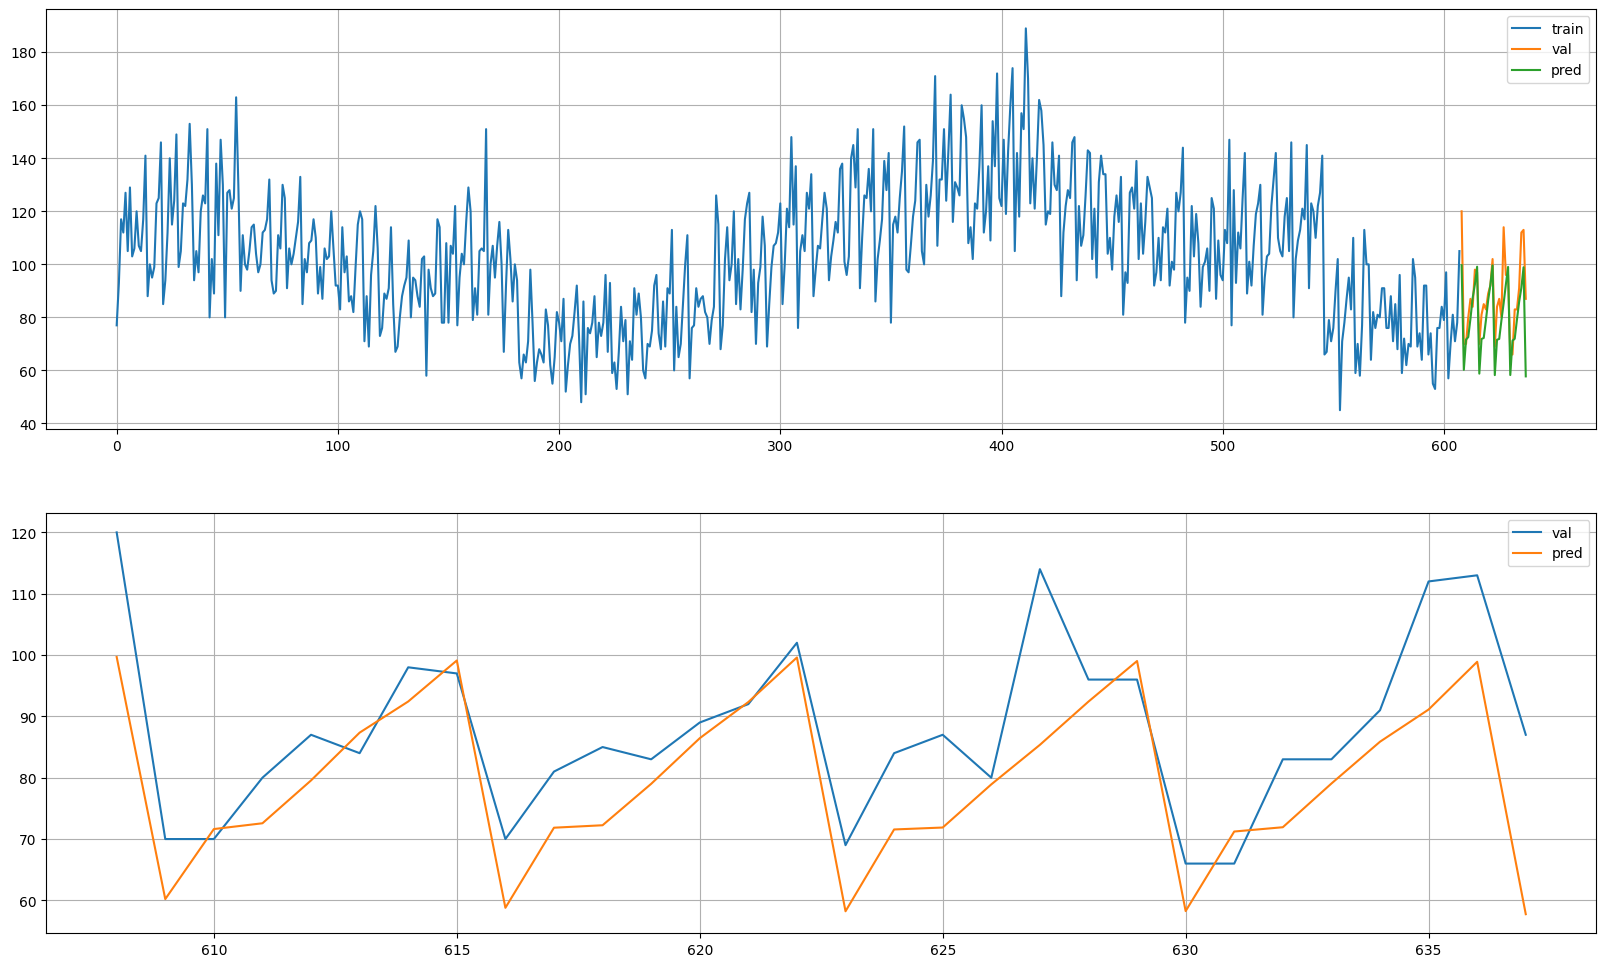

In [42]:
plot_model_result(y_train, y_val, pred)

# 5.모델링3 : SARIMAX
* 여기서는 feature에 대한 추가 없이, 기존 feature로만 모델링을 수행합니다.

## (1) 모델링

### 1) 학습

In [43]:
# 4번에서 찾은 최적의 하이퍼파라미터 + x_train 이용하여 모델 생성하기
m3_1 = sm.tsa.SARIMAX(y_train,
                      order=(5,1,4),
                      seasonal_order=(2,1,3,7),
                      exog=x_train).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


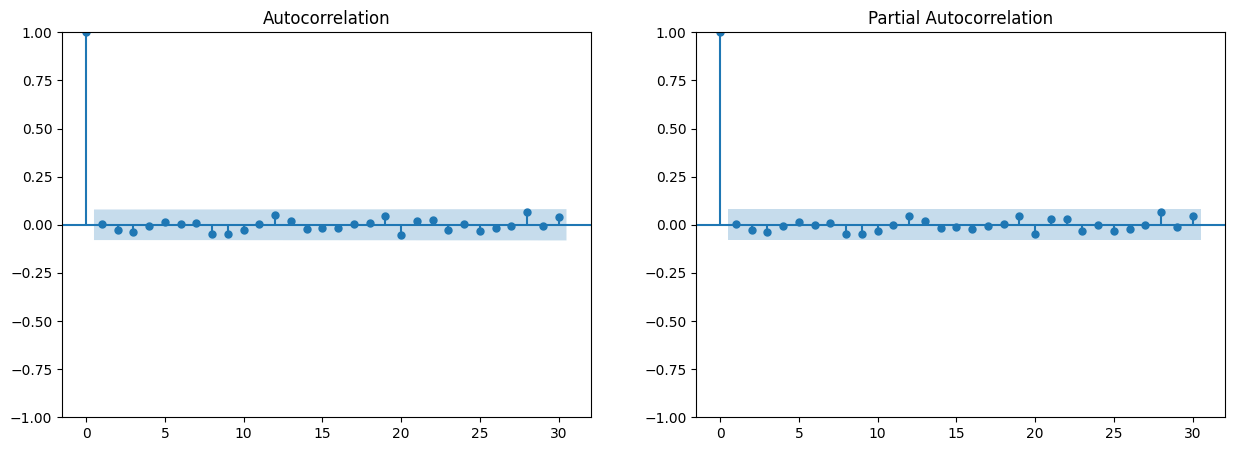

In [44]:
residuals = m3_1.resid
residual_diag(residuals)

#### ② AIC

#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 exog=x_val 옵션이 들어가야 함.

In [46]:
pred = m3_1.forecast(val_size,  exog=x_val)

print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 8.504106099949153
MAPE: 0.09693362565420441
R2  :  0.46590418128121924


* 결과 시각화

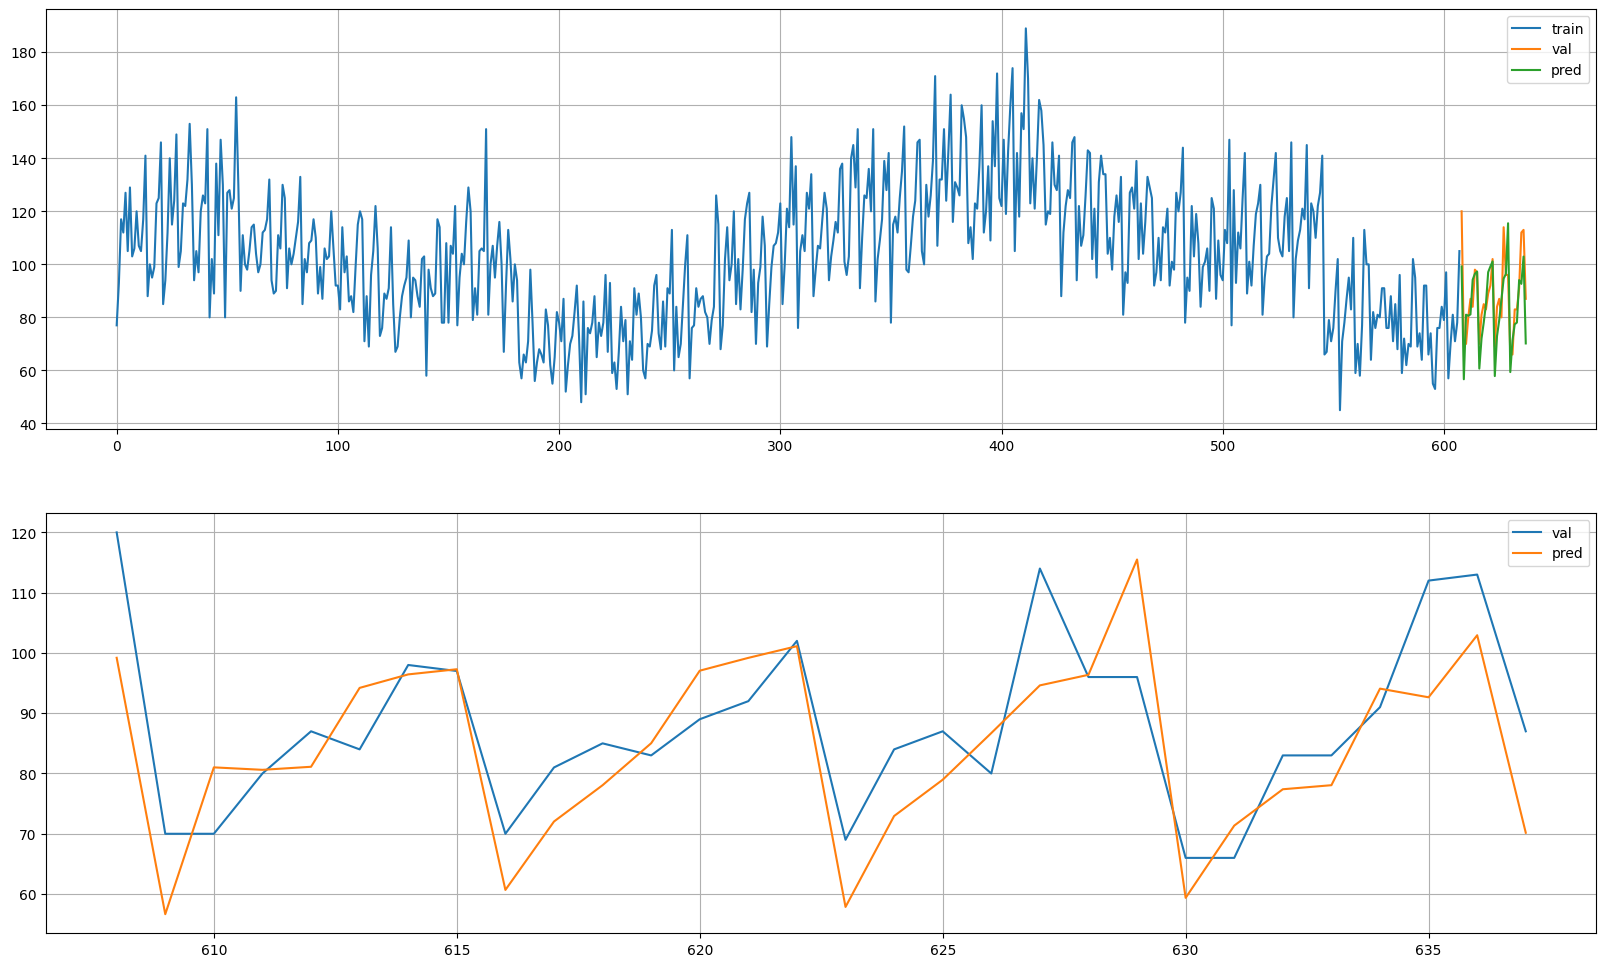

In [47]:
plot_model_result(y_train, y_val, pred)

# 6.예측결과 저장
* joblib을 이용하여
* 가장 성능이 좋았던 모델의 예측 결과를 저장합니다.


In [50]:
import joblib

joblib.dump(pred1, 'pred_22.pkl')

['pred_22.pkl']

**저장된 파일을 다운로드 받으세요.**
* 왼쪽 파일 탭 > 저장한 파일 오른쪽 클릭 > 다운로드